# BA x AI Final Project (Option A): Pre‑Call Targeting for Bank Telemarketing

This notebook implements **Steps 1–3** from `OptionA_DirectMarketing_TechnicalPlan.md`:

1. Define the **technical outputs** required for the project.
2. Set up a **reproducible environment** (seeds + package versions).
3. **Fetch the dataset** and print **data provenance** + a compact dataset snapshot.

> Note: If `ucimlrepo` is not installed in your environment, install it before running Step 3.


In [12]:
# Step 1 — Required technical outputs (high level)

PROJECT_OUTPUTS = {
    "provenance": [
        "dataset source URL + DOI + licence + access date",
        "rows/features + target definition + class balance",
        "Option A feature availability table (included vs excluded)",
    ],
    "models": [
        "Dummy baseline",
        "Logistic regression (interpretable)",
        "One tree-based model (nonlinear)",
        "(Optional) calibrated probabilities",
    ],
    "evaluation": [
        "PR curve + PR-AUC (primary)",
        "ROC curve + ROC-AUC (secondary)",
        "Calibration curve + Brier score",
        "Lift/gains and precision@K / recall@K",
        "Profit curves vs K and vs threshold + sensitivity over (P, C)",
    ],
    "interpretation": [
        "Top logistic coefficients (business-readable)",
        "Permutation importance for tree model",
    ],
    "reproducibility": [
        "random seeds",
        "train/validation/test split details",
        "model hyperparameters",
        "package versions",
    ],
}

for section, items in PROJECT_OUTPUTS.items():
    print(f"\n{section.upper()}")
    for item in items:
        print(f"- {item}")



PROVENANCE
- dataset source URL + DOI + licence + access date
- rows/features + target definition + class balance
- Option A feature availability table (included vs excluded)

MODELS
- Dummy baseline
- Logistic regression (interpretable)
- One tree-based model (nonlinear)
- (Optional) calibrated probabilities

EVALUATION
- PR curve + PR-AUC (primary)
- ROC curve + ROC-AUC (secondary)
- Calibration curve + Brier score
- Lift/gains and precision@K / recall@K
- Profit curves vs K and vs threshold + sensitivity over (P, C)

INTERPRETATION
- Top logistic coefficients (business-readable)
- Permutation importance for tree model

REPRODUCIBILITY
- random seeds
- train/validation/test split details
- model hyperparameters
- package versions


In [13]:
# Step 2 — Environment & reproducibility setup

import os
import platform
import random
import subprocess
import sys
from datetime import datetime, timezone
import importlib.metadata as md
import importlib.util

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)

ACCESS_UTC = datetime.now(timezone.utc)

# Install (once) any missing libraries used in the project.
# Keeping this in one place makes later cells cleaner and easier to read.
REQUIRED = {
    "numpy": "numpy",
    "pandas": "pandas",
    "ucimlrepo": "ucimlrepo",
    "sklearn": "scikit-learn",
    "matplotlib": "matplotlib",
    "seaborn": "seaborn",
    "IPython": "ipython",
}

missing_dists = sorted({dist for mod, dist in REQUIRED.items() if importlib.util.find_spec(mod) is None})
if missing_dists:
    print("Installing missing packages:", ", ".join(missing_dists))
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *missing_dists])

missing_mods = [mod for mod in REQUIRED if importlib.util.find_spec(mod) is None]
if missing_mods:
    raise ModuleNotFoundError(
        "Missing required modules after installation: " + ", ".join(missing_mods)
    )

import numpy as np
import pandas as pd

np.random.seed(SEED)

def pkg_version(dist_name: str) -> str:
    try:
        return md.version(dist_name)
    except md.PackageNotFoundError:
        return "not-installed"

env_info = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "seed": SEED,
    "accessed_utc": ACCESS_UTC.isoformat(timespec="seconds"),
    "numpy": pkg_version("numpy"),
    "pandas": pkg_version("pandas"),
    "scikit-learn": pkg_version("scikit-learn"),
    "matplotlib": pkg_version("matplotlib"),
    "seaborn": pkg_version("seaborn"),
    "ucimlrepo": pkg_version("ucimlrepo"),
}

print("Environment / Reproducibility Info")
for k, v in env_info.items():
    print(f"- {k}: {v}")


Environment / Reproducibility Info
- python: 3.11.14
- platform: macOS-26.2-arm64-arm-64bit
- seed: 42
- accessed_utc: 2025-12-29T05:33:42+00:00
- numpy: 2.4.0
- pandas: 2.3.3
- scikit-learn: 1.8.0
- matplotlib: 3.10.8
- seaborn: 0.13.2
- ucimlrepo: 0.0.7


## Step 3 — Data Ingest and Provenance

This cell fetches the UCI **Bank Marketing** dataset (id=222) via `ucimlrepo` and prints:
- A provenance block (source URLs, DOI, licence, access timestamp) for referencing
- A compact dataset snapshot (shape, target balance, and top missingness rates)
- The variable information table provided by UCI metadata


In [14]:
# Step 3 — Data ingest + provenance report (UCI Bank Marketing, id=222)

from ucimlrepo import fetch_ucirepo
from IPython.display import display

DATASET_ID = 222

try:
    bank_marketing = fetch_ucirepo(id=DATASET_ID)
except Exception as e:
    raise RuntimeError(
        "Failed to fetch UCI dataset id=222 via ucimlrepo. "
        "Check your internet access (or whether the dataset is cached in your environment)."
    ) from e

# Data
X_raw = bank_marketing.data.features.copy()
y_raw = bank_marketing.data.targets.iloc[:, 0].copy()

# Provenance (for assignment reporting)
provenance = {
    "dataset_name": bank_marketing.metadata.get("name", "Bank Marketing"),
    "uci_id": bank_marketing.metadata.get("uci_id", DATASET_ID),
    "repository_url": bank_marketing.metadata.get(
        "repository_url", "https://archive.ics.uci.edu/dataset/222/bank+marketing"
    ),
    "data_url": bank_marketing.metadata.get(
        "data_url", "https://archive.ics.uci.edu/static/public/222/data.csv"
    ),
    "dataset_doi": bank_marketing.metadata.get("dataset_doi", "10.24432/C5K306"),
    "licence": "CC BY 4.0 (as listed on UCI)",
    "accessed_utc": ACCESS_UTC.isoformat(timespec="seconds"),
}

print("Data provenance")
for k, v in provenance.items():
    print(f"- {k}: {v}")

print("\nDataset snapshot")
print(f"- rows: {X_raw.shape[0]:,}")
print(f"- features: {X_raw.shape[1]}")
print(f"- feature columns: {list(X_raw.columns)}")

target_counts = y_raw.value_counts(dropna=False)
positive_rate = float((y_raw == "yes").mean()) if y_raw.dtype == object else float("nan")
print("\nTarget distribution (y)")
display(target_counts.to_frame(name="count"))
print(f"- positive rate (y == 'yes'): {positive_rate:.4f}")

print("\nMissingness (NaN) — top columns")
missing_rate = X_raw.isna().mean().sort_values(ascending=False)
missing_tbl = (
    missing_rate[missing_rate > 0]
    .mul(100)
    .round(2)
    .rename("missing_%")
    .to_frame()
)
display(missing_tbl.head(10))

print("\nVariable information (from UCI metadata)")
display(bank_marketing.variables)


Data provenance
- dataset_name: Bank Marketing
- uci_id: 222
- repository_url: https://archive.ics.uci.edu/dataset/222/bank+marketing
- data_url: https://archive.ics.uci.edu/static/public/222/data.csv
- dataset_doi: 10.24432/C5K306
- licence: CC BY 4.0 (as listed on UCI)
- accessed_utc: 2025-12-29T05:33:42+00:00

Dataset snapshot
- rows: 45,211
- features: 16
- feature columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

Target distribution (y)


,count
y,
no,39922
yes,5289


- positive rate (y == 'yes'): 0.1170

Missingness (NaN) — top columns


,missing_%
poutcome,81.75
contact,28.80
education,4.11
job,0.64



Variable information (from UCI metadata)


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",None,no
4,default,Feature,Binary,None,has credit in default?,None,no
5,balance,Feature,Integer,None,average yearly balance,euros,no
6,housing,Feature,Binary,None,has housing loan?,None,no
7,loan,Feature,Binary,None,has personal loan?,None,no
8,contact,Feature,Categorical,None,contact communication type (categorical: 'cell...,None,yes
9,day_of_week,Feature,Date,None,last contact day of the week,None,no


## Step 4 — Decision‑Focused EDA (Option A)

Goal: examine the dataset *as a decision problem* and prepare for a **pre‑call targeting** model.

This section focuses on:
- Target imbalance (how rare is subscription?)
- Missingness and what it means in business terms (e.g., no prior campaign history)
- Sanity checks (duplicates, special codes like `pdays = -1`)
- A clear **feature availability** table for Option A (what is known *before* calling vs. leakage)


In [15]:
# Step 4 — Data examination (EDA) focused on what matters for the decision

import numpy as np
import pandas as pd
from IPython.display import display

assert "X_raw" in globals() and "y_raw" in globals(), "Run Step 3 first to create X_raw and y_raw."

n_rows = len(X_raw)

print("Dataset overview")
print(f"- rows: {n_rows:,}")
print(f"- features: {X_raw.shape[1]}")
print(f"- target positive rate (y == 'yes'): {(y_raw == 'yes').mean():.4f}")

print("\nDuplicate checks")
print(f"- duplicate rows in features (X_raw): {int(X_raw.duplicated().sum())}")
print(f"- duplicate rows in (X_raw, y_raw): {int(pd.concat([X_raw, y_raw.rename('y')], axis=1).duplicated().sum())}")

print("\nMissingness and cardinality summary")
summary = pd.DataFrame(
    {
        "dtype": X_raw.dtypes.astype(str),
        "n_missing": X_raw.isna().sum(),
        "missing_%": (X_raw.isna().mean() * 100).round(2),
        "n_unique": X_raw.nunique(dropna=False),
    }
).sort_values(["missing_%", "n_unique"], ascending=[False, False])
display(summary)

categorical_cols = [c for c in X_raw.columns if X_raw[c].dtype == "object"]
numeric_cols = [c for c in X_raw.columns if c not in categorical_cols]

print("\nCategorical columns (top values)")
for col in categorical_cols:
    vc = X_raw[col].value_counts(dropna=False)
    top = vc.head(8).to_frame(name="count")
    top["pct"] = (top["count"] / n_rows * 100).round(2)
    print(f"\n- {col} (unique incl NaN: {int(X_raw[col].nunique(dropna=False))}, missing: {int(X_raw[col].isna().sum())})")
    display(top)

print("\nNumeric columns (summary stats)")
display(X_raw[numeric_cols].describe().T)

# Sanity check: pdays uses -1 as a sentinel for "not previously contacted".
if "pdays" in X_raw.columns:
    pdays = X_raw["pdays"]
    n_not_prev = int((pdays == -1).sum())
    print("\nSanity checks: prior contact history")
    print(f"- pdays == -1 count (not previously contacted): {n_not_prev:,} ({n_not_prev / n_rows:.2%})")
    if n_not_prev < n_rows:
        display(pdays[pdays != -1].describe().to_frame(name="pdays (excluding -1)"))

# Business meaning of missingness: poutcome is often missing when there was no prior campaign.
if "poutcome" in X_raw.columns and "pdays" in X_raw.columns:
    prev_contacted = X_raw["pdays"] != -1
    ctab = pd.crosstab(prev_contacted, X_raw["poutcome"].isna(), normalize="index")
    ctab.index = ctab.index.map({False: "prev_contacted = 0", True: "prev_contacted = 1"})
    if list(ctab.columns) == [False, True]:
        ctab.columns = ["poutcome present", "poutcome missing"]
    print("\nMissingness meaning check (poutcome vs prior contact)")
    display(ctab.round(3))

# Leakage illustration (do not use duration in Option A): it is only known after the call.
if "duration" in X_raw.columns:
    leak_tbl = (
        pd.DataFrame({"duration": X_raw["duration"], "y": y_raw})
        .groupby("y")["duration"]
        .agg(["count", "mean", "median"])
    )
    print("\nLeakage check (duration differs sharply by outcome; excluded in Option A)")
    display(leak_tbl)

# Option A feature availability table (include vs exclude)
OPTION_A_INCLUDE = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "balance",
    "housing",
    "loan",
    "pdays",
    "previous",
    "poutcome",
]

OPTION_A_EXCLUDE = {
    "duration": "Post-call variable (only known after placing the call) → leakage.",
    "campaign": "Depends on how many times the client is contacted during the campaign (not known pre-call).",
    "contact": "Operational/scheduling detail from the last contact (not a stable pre-call customer attribute).",
    "month": "Timing of the last contact; in Option A we assume targeting is decided before scheduling.",
    "day_of_week": "Recorded day-of-month (1–31) for the last contact; excluded for pre-call targeting.",
}

missing_in_include = [c for c in OPTION_A_INCLUDE if c not in X_raw.columns]
if missing_in_include:
    raise KeyError(f"Option A expected columns not found in X_raw: {missing_in_include}")

availability_rows = []
for feature in X_raw.columns:
    if feature in OPTION_A_INCLUDE:
        availability_rows.append(
            {
                "feature": feature,
                "option_a": "include",
                "availability": "Known pre-call (CRM / account / prior-campaign history)",
                "rationale": "Eligible for pre-call propensity scoring.",
            }
        )
    elif feature in OPTION_A_EXCLUDE:
        availability_rows.append(
            {
                "feature": feature,
                "option_a": "exclude",
                "availability": "Not reliably known pre-call / depends on call execution",
                "rationale": OPTION_A_EXCLUDE[feature],
            }
        )
    else:
        availability_rows.append(
            {
                "feature": feature,
                "option_a": "exclude",
                "availability": "Not used in Option A",
                "rationale": "Excluded to keep the model aligned to the pre-call decision moment.",
            }
        )

feature_availability = pd.DataFrame(availability_rows)
feature_availability["missing_%"] = feature_availability["feature"].map(
    lambda c: round(float(X_raw[c].isna().mean() * 100), 2)
)
feature_availability["option_a_order"] = (
    feature_availability["option_a"].map({"include": 0, "exclude": 1}).fillna(9).astype(int)
)
feature_availability = (
    feature_availability.sort_values(
        ["option_a_order", "missing_%", "feature"], ascending=[True, False, True]
    ).drop(columns=["option_a_order"])
)

print("\nOption A feature availability (include vs exclude)")
display(feature_availability)

print("\nNext: Step 5 will engineer features (e.g., prev_contacted) and build a leakage-safe preprocessing pipeline.")


Dataset overview
- rows: 45,211
- features: 16
- target positive rate (y == 'yes'): 0.1170

Duplicate checks
- duplicate rows in features (X_raw): 0
- duplicate rows in (X_raw, y_raw): 0

Missingness and cardinality summary


,dtype,n_missing,missing_%,n_unique
poutcome,object,36959,81.75,4
contact,object,13020,28.80,3
education,object,1857,4.11,4
job,object,288,0.64,12
balance,int64,0,0.00,7168
duration,int64,0,0.00,1573
pdays,int64,0,0.00,559
age,int64,0,0.00,77
campaign,int64,0,0.00,48
previous,int64,0,0.00,41



Categorical columns (top values)

- job (unique incl NaN: 12, missing: 288)


,count,pct
job,,
blue-collar,9732,21.53
management,9458,20.92
technician,7597,16.80
admin.,5171,11.44
services,4154,9.19
retired,2264,5.01
self-employed,1579,3.49
entrepreneur,1487,3.29



- marital (unique incl NaN: 3, missing: 0)


,count,pct
marital,,
married,27214,60.19
single,12790,28.29
divorced,5207,11.52



- education (unique incl NaN: 4, missing: 1857)


,count,pct
education,,
secondary,23202,51.32
tertiary,13301,29.42
primary,6851,15.15
NaN,1857,4.11



- default (unique incl NaN: 2, missing: 0)


,count,pct
default,,
no,44396,98.2
yes,815,1.8



- housing (unique incl NaN: 2, missing: 0)


,count,pct
housing,,
yes,25130,55.58
no,20081,44.42



- loan (unique incl NaN: 2, missing: 0)


,count,pct
loan,,
no,37967,83.98
yes,7244,16.02



- contact (unique incl NaN: 3, missing: 13020)


,count,pct
contact,,
cellular,29285,64.77
NaN,13020,28.80
telephone,2906,6.43



- month (unique incl NaN: 12, missing: 0)


,count,pct
month,,
may,13766,30.45
jul,6895,15.25
aug,6247,13.82
jun,5341,11.81
nov,3970,8.78
apr,2932,6.49
feb,2649,5.86
jan,1403,3.10



- poutcome (unique incl NaN: 4, missing: 36959)


,count,pct
poutcome,,
NaN,36959,81.75
failure,4901,10.84
other,1840,4.07
success,1511,3.34



Numeric columns (summary stats)


,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day_of_week,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0



Sanity checks: prior contact history
- pdays == -1 count (not previously contacted): 36,954 (81.74%)


,pdays (excluding -1)
count,8257.000000
mean,224.577692
std,115.344035
min,1.000000
25%,133.000000
50%,194.000000
75%,327.000000
max,871.000000



Missingness meaning check (poutcome vs prior contact)


,poutcome present,poutcome missing
pdays,,
prev_contacted = 0,0.000,1.000
prev_contacted = 1,0.999,0.001



Leakage check (duration differs sharply by outcome; excluded in Option A)


,count,mean,median
y,,,
no,39922,221.182806,164.0
yes,5289,537.294574,426.0



Option A feature availability (include vs exclude)


,feature,option_a,availability,rationale,missing_%
15,poutcome,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,81.75
3,education,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,4.11
1,job,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.64
0,age,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
5,balance,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
4,default,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
6,housing,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
7,loan,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
2,marital,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00
13,pdays,include,Known pre-call (CRM / account / prior-campaign...,Eligible for pre-call propensity scoring.,0.00



Next: Step 5 will engineer features (e.g., prev_contacted) and build a leakage-safe preprocessing pipeline.


### Step 4 (Plots) — Visual EDA for the decision story

The presentation benefits from a few clean visuals that directly support the decision framing:
- Class imbalance (subscriptions are rare)
- Missingness patterns (e.g., prior campaign history)
- Evidence that some **pre‑call** fields are useful signals (e.g., prior outcome, credit/loan indicators)

Plots use `matplotlib`/`seaborn`, installed earlier in **Step 2**.


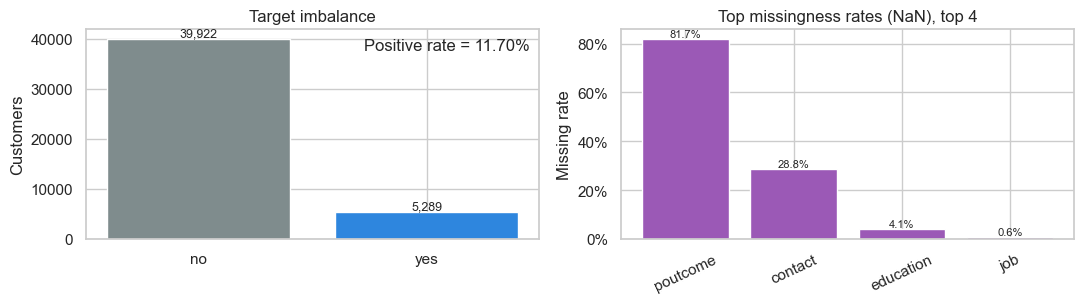

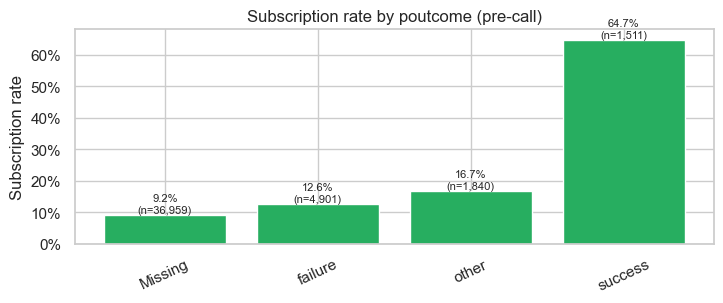

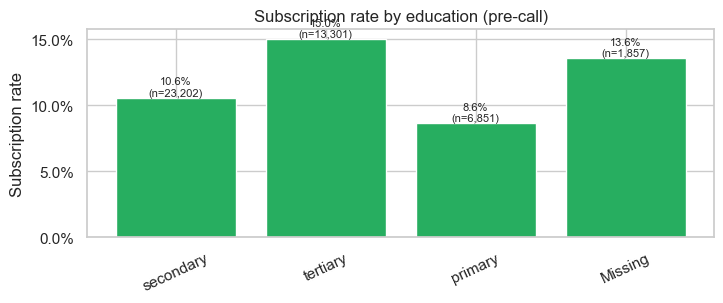

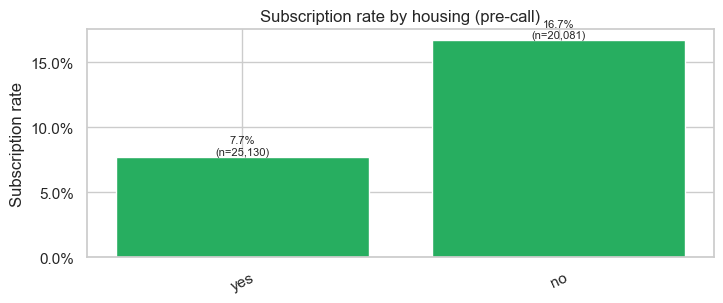

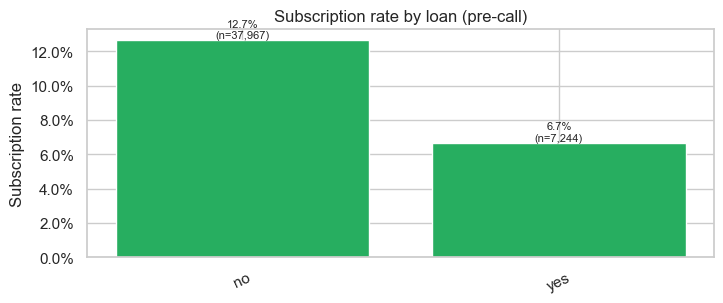

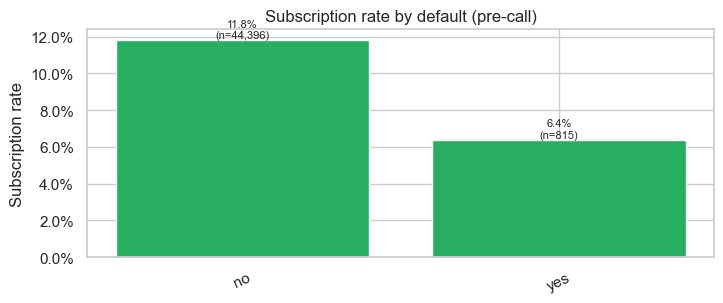

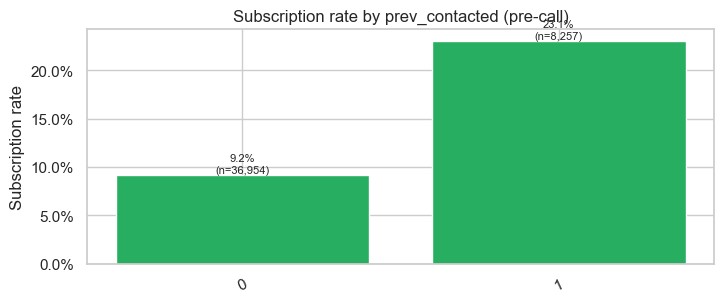

/var/folders/vw/p_gkg8fj4qnd_0h383bdw55h0000gn/T/ipykernel_64237/3372725346.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([x0, x1], labels=["no", "yes"], showfliers=False)
/var/folders/vw/p_gkg8fj4qnd_0h383bdw55h0000gn/T/ipykernel_64237/3372725346.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([x0, x1], labels=["no", "yes"], showfliers=False)


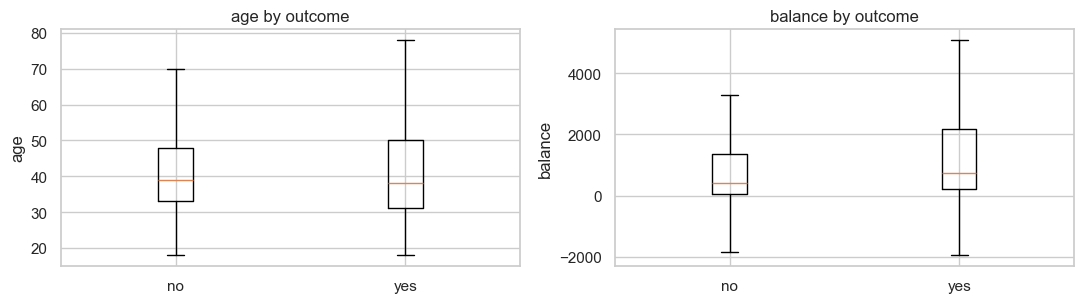

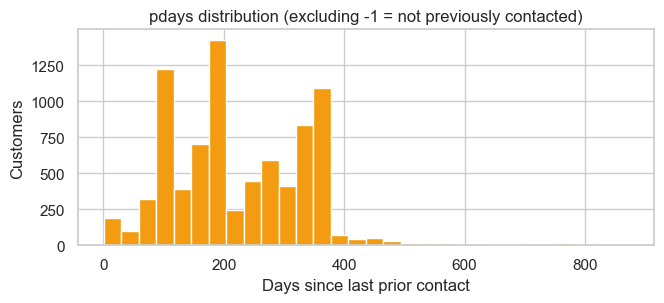

In [16]:
# Step 4 — EDA plots (decision-focused)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

assert "X_raw" in globals() and "y_raw" in globals(), "Run Step 3 first to create X_raw and y_raw."

sns.set_theme(style="whitegrid")

y_bin = (y_raw == "yes").astype(int)
df = X_raw.copy()
df["y"] = y_bin
df["prev_contacted"] = (df["pdays"] != -1).astype(int)

def plot_target_and_missingness(X: pd.DataFrame, y01: pd.Series, top_n: int = 6) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(11, 3.2))

    # Target imbalance
    counts = y01.value_counts().sort_index()
    labels = ["no", "yes"]
    axes[0].bar(labels, counts.values, color=["#7f8c8d", "#2e86de"])
    axes[0].set_title("Target imbalance")
    axes[0].set_ylabel("Customers")
    for i, v in enumerate(counts.values):
        axes[0].text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=9)
    axes[0].text(0.98, 0.9, f"Positive rate = {float(y01.mean()):.2%}", transform=axes[0].transAxes, ha="right")

    # Missingness
    miss = X.isna().mean().sort_values(ascending=False)
    miss = miss[miss > 0].head(top_n)
    axes[1].bar(miss.index.astype(str), miss.values, color="#9b59b6")
    axes[1].set_title(f"Top missingness rates (NaN), top {len(miss)}")
    axes[1].set_ylabel("Missing rate")
    axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))
    axes[1].tick_params(axis="x", rotation=25)
    for i, v in enumerate(miss.values):
        axes[1].text(i, v, f"{v:.1%}", ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()


def plot_rate_by_category(df0: pd.DataFrame, col: str, top_n: int = 8, min_count: int = 200) -> None:
    s = df0[col].astype(object).where(df0[col].notna(), "Missing")
    agg = (
        df0.assign(_cat=s)
        .groupby("_cat")["y"]
        .agg(rate="mean", n="count")
        .sort_values("n", ascending=False)
    )
    agg = agg[agg["n"] >= min_count].head(top_n)
    if agg.empty:
        print(f"Not enough rows to plot '{col}' (min_count={min_count}).")
        return

    fig, ax = plt.subplots(figsize=(7.4, 3.2))
    ax.bar(agg.index.astype(str), agg["rate"].values, color="#27ae60")
    ax.set_title(f"Subscription rate by {col} (pre-call)")
    ax.set_ylabel("Subscription rate")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.tick_params(axis="x", rotation=25)
    for i, (rate, n) in enumerate(zip(agg["rate"].values, agg["n"].values)):
        ax.text(i, rate, f"{rate:.1%}\n(n={int(n):,})", ha="center", va="bottom", fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_numeric_boxplots(df0: pd.DataFrame, cols: list[str]) -> None:
    fig, axes = plt.subplots(1, len(cols), figsize=(11, 3.2))
    if len(cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, cols):
        x0 = df0.loc[df0["y"] == 0, col].dropna()
        x1 = df0.loc[df0["y"] == 1, col].dropna()
        ax.boxplot([x0, x1], labels=["no", "yes"], showfliers=False)
        ax.set_title(f"{col} by outcome")
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


def plot_pdays_histogram(df0: pd.DataFrame) -> None:
    s = df0.loc[df0["pdays"] != -1, "pdays"].dropna()
    if s.empty:
        print("No non--1 pdays values to plot.")
        return
    fig, ax = plt.subplots(figsize=(6.8, 3.2))
    ax.hist(s.values, bins=30, color="#f39c12", edgecolor="white")
    ax.set_title("pdays distribution (excluding -1 = not previously contacted)")
    ax.set_xlabel("Days since last prior contact")
    ax.set_ylabel("Customers")
    plt.tight_layout()
    plt.show()


# Plot A: class imbalance + missingness overview
plot_target_and_missingness(X_raw, y_bin, top_n=6)

# Plot B: subscription rate by key pre-call categorical features
for col in ["poutcome", "education", "housing", "loan", "default", "prev_contacted"]:
    plot_rate_by_category(df, col=col, top_n=8, min_count=200)

# Plot C: numeric distributions by outcome (pre-call)
plot_numeric_boxplots(df, ["age", "balance"])

# Plot D: prior-contact timing distribution
plot_pdays_histogram(df)


## Step 5 — Feature Engineering & Preprocessing (Leakage‑Safe, Option A)

Goal: create the **pre‑call** modeling dataset and define a reusable preprocessing pipeline.

Key points for scoring well:
- The model must match the decision moment (**pre‑call**). We exclude post‑call/execution fields (especially `duration`).
- We handle `pdays = -1` explicitly:
  - `prev_contacted` indicates whether the customer has prior campaign history.
  - `pdays_clean` replaces `-1` with `NaN` so “days since prior contact” is only defined when it exists.
- We use a scikit‑learn `Pipeline`/`ColumnTransformer` to make preprocessing reproducible and leakage‑resistant (fit on training data later).


In [17]:
# Step 5 — Build the Option A (pre-call) modeling frame + preprocessing pipelines

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

assert "X_raw" in globals() and "y_raw" in globals(), "Run Step 3 first to create X_raw and y_raw."
assert "SEED" in globals(), "Run Step 2 first to set SEED."

# Option A: only features plausibly known BEFORE placing the call.
OPTION_A_BASE_FEATURES = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "balance",
    "housing",
    "loan",
    "pdays",
    "previous",
    "poutcome",
]

missing_cols = [c for c in OPTION_A_BASE_FEATURES if c not in X_raw.columns]
if missing_cols:
    raise KeyError(f"Missing expected Option A columns in X_raw: {missing_cols}")

# Target: convert to 0/1 (positive class = subscribed)
y = (y_raw == "yes").astype(int)

# Start from pre-call features
X = X_raw[OPTION_A_BASE_FEATURES].copy()

# Feature engineering for prior-contact history
X["prev_contacted"] = (X["pdays"] != -1).astype(int)
X["pdays_clean"] = X["pdays"].replace(-1, np.nan)

# Use pdays_clean + prev_contacted instead of raw pdays (-1 sentinel).
X_model = X.drop(columns=["pdays"]).copy()

# Define column roles
CATEGORICAL_COLS = ["job", "marital", "education", "default", "housing", "loan", "poutcome"]
NUMERIC_COLS = ["age", "balance", "previous", "pdays_clean", "prev_contacted"]

role_missing = [c for c in CATEGORICAL_COLS + NUMERIC_COLS if c not in X_model.columns]
if role_missing:
    raise KeyError(f"Column-role mapping references missing columns: {role_missing}")

print("Option A modeling frame")
print(f"- X_model shape: {X_model.shape}")
print(f"- y positive rate: {float(y.mean()):.4f}")
print("- categorical cols:", CATEGORICAL_COLS)
print("- numeric cols:", NUMERIC_COLS)

print("\nDtypes and missingness (modeling columns)")
eda_model_summary = pd.DataFrame(
    {
        "dtype": X_model.dtypes.astype(str),
        "missing_%": (X_model.isna().mean() * 100).round(2),
        "n_unique": X_model.nunique(dropna=False),
    }
).loc[CATEGORICAL_COLS + NUMERIC_COLS]
display(eda_model_summary)

# Preprocessing pipelines
categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

# Logistic regression benefits from scaling numeric features.
numeric_pipe_lr = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Tree models typically do not need scaling.
numeric_pipe_tree = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

preprocess_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_lr, NUMERIC_COLS),
        ("cat", categorical_pipe, CATEGORICAL_COLS),
    ],
    remainder="drop",
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_tree, NUMERIC_COLS),
        ("cat", categorical_pipe, CATEGORICAL_COLS),
    ],
    remainder="drop",
)

# Smoke test on a sample ONLY (avoid fitting on the full dataset before splitting).
sample_n = min(2000, len(X_model))
sample_idx = X_model.sample(n=sample_n, random_state=SEED).index
X_sample = X_model.loc[sample_idx]

Xt_lr = clone(preprocess_lr).fit_transform(X_sample)
Xt_tree = clone(preprocess_tree).fit_transform(X_sample)

print("\nPreprocessing smoke test (fit on sample only)")
print(f"- lr design matrix shape: {Xt_lr.shape}")
print(f"- tree design matrix shape: {Xt_tree.shape}")
print("\nNext: Step 6 will create train/validation/test splits and fit these preprocessors ONLY on training data.")


Option A modeling frame
- X_model shape: (45211, 12)
- y positive rate: 0.1170
- categorical cols: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
- numeric cols: ['age', 'balance', 'previous', 'pdays_clean', 'prev_contacted']

Dtypes and missingness (modeling columns)


,dtype,missing_%,n_unique
job,object,0.64,12
marital,object,0.00,3
education,object,4.11,4
default,object,0.00,2
housing,object,0.00,2
loan,object,0.00,2
poutcome,object,81.75,4
age,int64,0.00,77
balance,int64,0.00,7168
previous,int64,0.00,41



Preprocessing smoke test (fit on sample only)
- lr design matrix shape: (2000, 34)
- tree design matrix shape: (2000, 34)

Next: Step 6 will create train/validation/test splits and fit these preprocessors ONLY on training data.


## Step 6 — Data Splitting Strategy (Train / Validation / Test)

Goal: create a **held‑out test set** that we do *not* use for model selection.

- **Train (60%)**: fit models and preprocessing.
- **Validation (20%)**: choose hyperparameters and compare models.
- **Test (20%)**: final, unbiased evaluation and business impact estimates.

We use a **stratified** split to preserve the positive rate (~11.7%) in each subset.


In [18]:
# Step 6 — Train/validation/test split (stratified)

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.model_selection import train_test_split

assert "X_model" in globals() and "y" in globals(), "Run Step 5 first to create X_model and y."
assert "SEED" in globals(), "Run Step 2 first to set SEED."

# 80/20 split first (test is held out)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_model,
    y,
    test_size=0.20,
    random_state=SEED,
    stratify=y,
)

# Split remaining 80% into train/val = 60/20 overall
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 * 0.80 = 0.20
    random_state=SEED,
    stratify=y_temp,
)

def split_report(name: str, y_split: pd.Series) -> dict:
    return {
        "split": name,
        "n": int(len(y_split)),
        "positives": int(y_split.sum()),
        "positive_rate": float(y_split.mean()),
    }

report = pd.DataFrame(
    [
        split_report("train", y_train),
        split_report("validation", y_val),
        split_report("test (held out)", y_test),
    ]
)

print("Split summary")
display(report)

# Keep indices (useful for later debugging / reproducibility)
IDX_TRAIN = X_train.index
IDX_VAL = X_val.index
IDX_TEST = X_test.index

print("\nNext: Step 7 will fit models using ONLY the training split and select models using the validation split.")


Split summary


,split,n,positives,positive_rate
0,train,27126,3173,0.116973
1,validation,9042,1058,0.117010
2,test (held out),9043,1058,0.116997



Next: Step 7 will fit models using ONLY the training split and select models using the validation split.


## Step 7 — Modeling (Baseline → Interpretable → Strong)

Goal: build a defensible model ladder aligned to the business decision.

Models:
- **Baseline**: `DummyClassifier` (what happens if we do no ML?)
- **Interpretable**: Logistic Regression (calibrated probabilities, explainable drivers)
- **Stronger**: Random Forest (captures nonlinearities/interactions)

Selection criteria:
- Primary: **PR‑AUC** (best for imbalanced classification)
- Secondary: **ROC‑AUC**
- Business‑aligned: **precision@K / lift@K** for realistic call capacities (computed on validation only)


In [19]:
# Step 7 — Train baseline + candidate models (train only), evaluate on validation

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

assert "X_train" in globals() and "X_val" in globals(), "Run Step 6 first to create splits."
assert "preprocess_lr" in globals() and "preprocess_tree" in globals(), "Run Step 5 first to define preprocessors."
assert "SEED" in globals(), "Run Step 2 first to set SEED."

def precision_at_k(y_true: pd.Series, scores: np.ndarray, k: int) -> float:
    k = int(min(k, len(scores)))
    if k <= 0:
        return float("nan")
    order = np.argsort(-scores)[:k]
    return float(np.asarray(y_true)[order].mean())


def evaluate_binary_classifier(estimator, X_eval: pd.DataFrame, y_eval: pd.Series, k_list: list[int]) -> dict:
    proba = estimator.predict_proba(X_eval)[:, 1]
    base_rate = float(np.mean(y_eval))
    out = {
        "pr_auc": float(average_precision_score(y_eval, proba)),
        "roc_auc": float(roc_auc_score(y_eval, proba)),
        "base_rate": base_rate,
    }
    for k in k_list:
        k = int(min(k, len(y_eval)))
        p_at_k = precision_at_k(y_eval, proba, k)
        out[f"precision@{k}"] = p_at_k
        out[f"lift@{k}"] = float(p_at_k / base_rate) if base_rate > 0 else float("nan")
    return out


# Use validation-sized capacities for comparison (keep numbers meaningful for the call-list story)
K_CANDIDATES = [1000, 2000, 5000]
K_CANDIDATES = [k for k in K_CANDIDATES if k <= len(y_val)]
if not K_CANDIDATES:
    K_CANDIDATES = [len(y_val)]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

results = []

# 7.1 Baseline: Dummy (no ML)
dummy = DummyClassifier(strategy="prior")
dummy.fit(X_train, y_train)
dummy_metrics = evaluate_binary_classifier(dummy, X_val, y_val, K_CANDIDATES)
results.append({"model": "Dummy (prior)", **dummy_metrics})

# 7.2 Interpretable model: Logistic Regression (tune C)
lr_pipe = Pipeline(
    steps=[
        ("preprocess", clone(preprocess_lr)),
        (
            "model",
            LogisticRegression(
                max_iter=2000,
                class_weight="balanced",
                solver="liblinear",
            ),
        ),
    ]
)

lr_grid = {
    "model__C": [0.1, 0.3, 1.0, 3.0, 10.0],
}

lr_search = GridSearchCV(
    lr_pipe,
    param_grid=lr_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
lr_metrics = evaluate_binary_classifier(best_lr, X_val, y_val, K_CANDIDATES)
results.append(
    {
        "model": "Logistic Regression",
        "cv_pr_auc": float(lr_search.best_score_),
        "best_params": lr_search.best_params_,
        **lr_metrics,
    }
)

# 7.3 Stronger model: Random Forest (tune a small grid)
rf_pipe = Pipeline(
    steps=[
        ("preprocess", clone(preprocess_tree)),
        (
            "model",
            RandomForestClassifier(
                n_estimators=200,
                random_state=SEED,
                n_jobs=-1,
                class_weight="balanced_subsample",
            ),
        ),
    ]
)

rf_grid = {
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 5],
}

rf_search = GridSearchCV(
    rf_pipe,
    param_grid=rf_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
)
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
rf_metrics = evaluate_binary_classifier(best_rf, X_val, y_val, K_CANDIDATES)
results.append(
    {
        "model": "Random Forest",
        "cv_pr_auc": float(rf_search.best_score_),
        "best_params": rf_search.best_params_,
        **rf_metrics,
    }
)

# Results table (validation)
results_df = pd.DataFrame(results)
sort_cols = ["pr_auc", "roc_auc"]
results_df = results_df.sort_values(sort_cols, ascending=False)
print("Model comparison (validation set)")
display(results_df)

# Keep the two candidate models for later steps (calibration, test evaluation)
MODEL_DUMMY = dummy
MODEL_LR = best_lr
MODEL_RF = best_rf

print("\nNext: Step 8 will check probability calibration for the selected model(s), then Step 9 will evaluate on the held-out test set.")


/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API.

Model comparison (validation set)


,model,pr_auc,roc_auc,base_rate,precision@1000,lift@1000,precision@2000,lift@2000,precision@5000,lift@5000,cv_pr_auc,best_params
2,Random Forest,0.402671,0.747853,0.11701,0.437,3.734739,0.299,2.555348,0.1684,1.439199,0.362486,"{'model__max_depth': 10, 'model__min_samples_l..."
1,Logistic Regression,0.355265,0.721871,0.11701,0.385,3.290331,0.274,2.341690,0.1640,1.401595,0.340521,{'model__C': 1.0}
0,Dummy (prior),0.117010,0.500000,0.11701,0.110,0.940095,0.115,0.982826,0.1152,0.984535,NaN,NaN



Next: Step 8 will check probability calibration for the selected model(s), then Step 9 will evaluate on the held-out test set.
